In [2]:
# Import package
import h5py
import numpy as np
import sigpy.plot as pl
import sigpy as sp
%matplotlib notebook

In [3]:
import cfl

In [4]:
import matplotlib.pyplot as plt

In [5]:
#read dataset: brain dataset
h5_dataset_brain = h5py.File('rawdata_brain_radial_96proj_12ch.h5', 'r')

In [6]:
h5_dataset_rawdata_name = list(h5_dataset_brain.keys())[0]
h5_dataset_trajectory_name = list(h5_dataset_brain.keys())[1]

trajectory = h5_dataset_brain.get(h5_dataset_trajectory_name).value
rawdata = h5_dataset_brain.get(h5_dataset_rawdata_name).value

In [ ]:
cfl.writecfl("trajectory_brain",trajectory)

In [7]:
rawdata.shape

(1, 512, 96, 12)

<IPython.core.display.Javascript object>


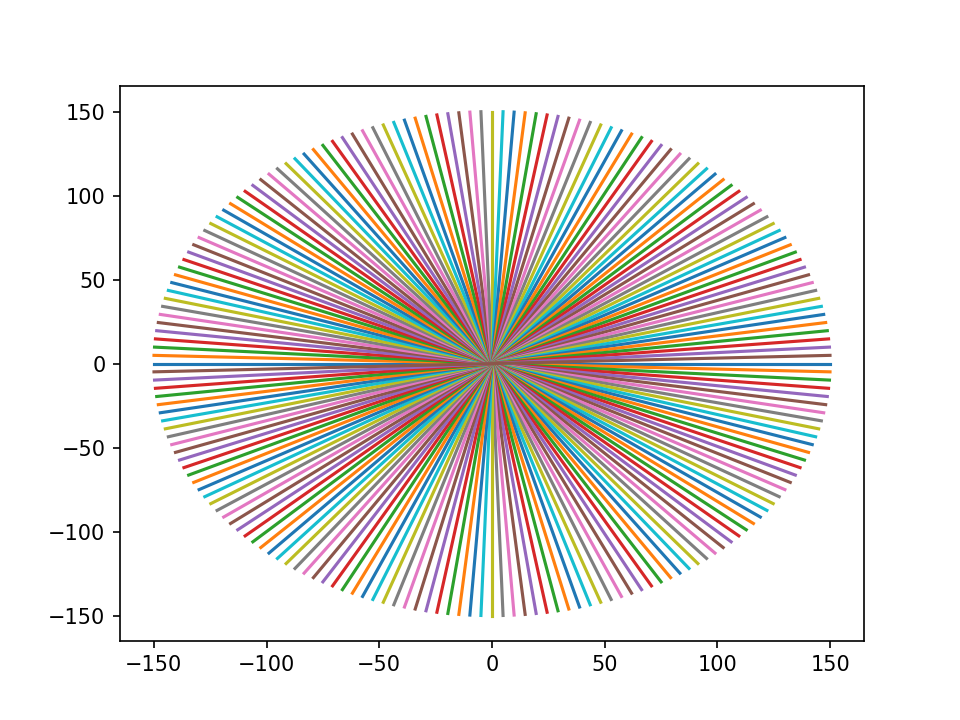

In [8]:
plt.plot(trajectory[0,:,:],trajectory[1,:,:])